In [7]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from Network_models import HD_cell, GD_cell, traj, circle_period
from scipy.signal import find_peaks
import matplotlib.colors as mcolors
import matplotlib.colorbar as mcolorbar
from scipy.ndimage import gaussian_filter1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### simulation the model

In [8]:

bm.set_dt(1.)
num_hd = 100
noise_stre = 0.1
v0 = 1.0*bm.pi/1000 #baseline speed
offset_len = 1/9
Animal_speed = 1.0*v0 #vary this to change the speed of the animal


num_hd = 100
noise_stre = 0.1
v0 = 1.0*bm.pi/1000 #baseline speed
offset_len = 1/9
Animal_speed = v0 #vary this to change the speed of the animal
A = 5. #1.6
mbar_gc = 20. 
mabr_hd = 12.

alpha_hd = 0.4
alpha_gc = 0.6

theta_modulation_stre_hd = alpha_hd * 1/v0 * Animal_speed
theta_modulation_stre_gc = alpha_gc * 1/v0 * Animal_speed

N = 4
# numT = int(N*np.pi/(bm.dt*Animal_speed))
numT = 4000

Grid_net = GD_cell(
    A = A, # 3
    a = 0.8,
    k = 1.0,
    tau = 10.,
    tau_v = 100.,
    mbar = mbar_gc,
    noise_stre = noise_stre,
    num_hd = num_hd,
)
HD_net = HD_cell(num=num_hd, 
                noise_stre = noise_stre/10, #gc has muhc more neurons than hd, 10000 vs 100
                tau=10., tau_v=100., 
                k=1., mbar=mabr_hd, a=0.4, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size

    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi+np.pi/2)
    ThetaModulator_GC = 1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi+np.pi/2)
    #calculate ThetaShutdown at time step i (whether to shut down the newtork activity or not)
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center #center of mass of internal direction
    HD_activity = HD_net.r 
    #update the grid cell network \
    Phase_Offset = offset_len
    Grid_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, Phase_Offset, Head_direction)
    
    #get results
    GC_bumpcenter = Grid_net.center
    center_grid_input = Grid_net.center_conjG
    GC_bumpactivity = Grid_net.r
    return GC_bumpcenter, Internal_direction, center_grid_input, GC_bumpactivity, HD_activity, ThetaModulator_GC


# run network

time_steps = np.arange(numT)

x = traj(x0=-np.pi, v=Animal_speed, T=numT)
Animal_location = bm.array([x, x]).transpose()
Head_direction = bm.pi/4*bm.ones(numT) #fixed head direction, mimicking the animal running in a straight line
Moving_speed = Animal_speed*bm.ones([numT,1])
#ThetaModulator = bm.ones(numT)+0.3*bm.sin(time_steps*2*bm.pi/100)
#ThetaShutdown = bm.zeros(numT)

center_grid, center_HD, center_grid_input, r_grid, r_HD, ThetaModulator_GC = bm.for_loop(
    run_CoupleNet, (time_steps, Animal_location, Head_direction, Moving_speed), progress_bar=True
    )


  0%|          | 0/4000 [00:00<?, ?it/s]

### calculate the HD sweep angle: hd_sweep_angle and the GC sweep angle: gc_sweep_angle

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_8490/2809178487.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 1.0, 'bump x offset')

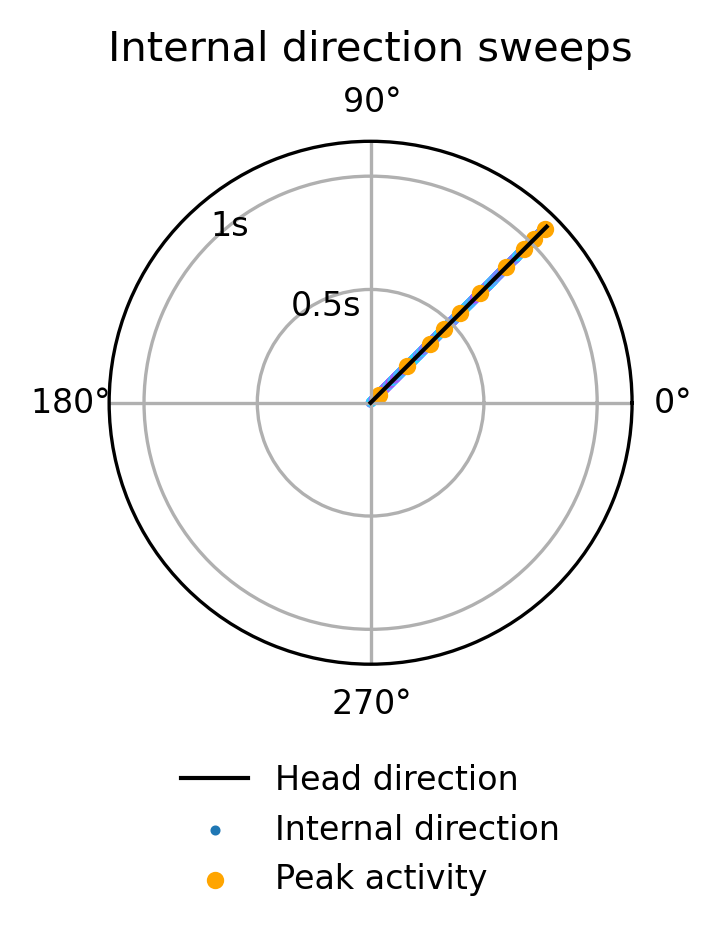

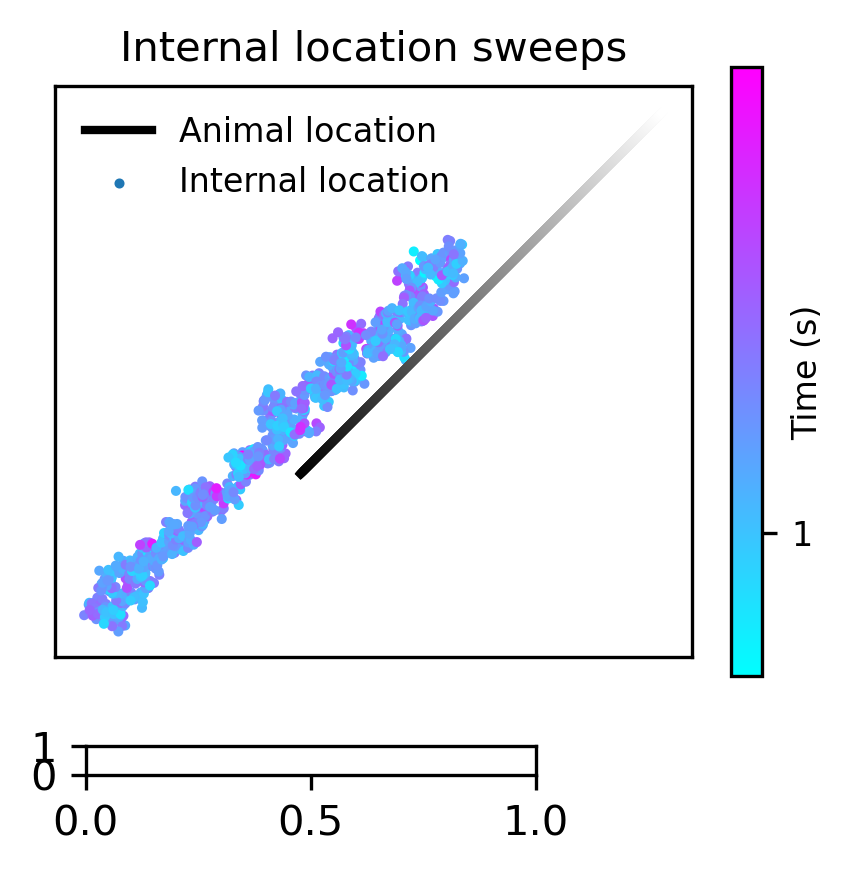

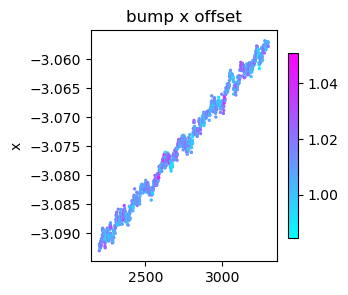

In [9]:
onecycleT = numT/(N/2)
start = int(numT - 0.9*onecycleT)
end = int(numT - 0.35*onecycleT)

max_r_grid = np.max(r_grid, axis=1)
max_bump_activity = np.max(r_HD, axis=1)

#plot internal direction and head direction in polar plot 1

fig,ax = plt.subplots(1, 1, figsize=(2.5, 3), dpi=300, subplot_kw={'projection': 'polar'})

labelsize = 10
ticksize = 8

s_size = 2

y = (time_steps[start:end]-time_steps[start])/1000

x = center_HD[start:end]
cb = ax.scatter(x,
                y,
                c=max_bump_activity[start:end], 
                cmap='cool', s=s_size, label='Internal direction')

#add peak of the activity as a orange dot to indicate the peak of the activity using pks_hdfr
max_fr = gaussian_filter1d(max_bump_activity[start:end], sigma=20) #sigma=30 more smooth to remove more than two peaks in a cycle
pks_hdfr, _ = find_peaks(max_fr)
ax.scatter(x[pks_hdfr], y[pks_hdfr], color='orange', s=10, label='Peak activity')
    

x = Head_direction[start:end]
ax.plot(x, y, linewidth=1, color='black', label='Head direction')

ax.legend(loc='lower center', fontsize=ticksize, bbox_to_anchor=(0.5, -0.5), frameon=False, ncol=1)

#xticks with 0 at east, 90 at north, 180 at west, 270 at south
ax.set_theta_zero_location("E")
#clockwise
ax.set_theta_direction(1)
#four x ticks
ax.set_xticks([0, bm.pi/2, bm.pi, 3*bm.pi/2])
ax.set_xticklabels([r'$0\degree$', r'$90\degree$', r'$180\degree$', r'$270\degree$'], fontsize=ticksize)
#yticks 
ax.set_yticks([0.5, 1])
ax.set_yticklabels(['0.5s','1s'], fontsize=ticksize)
#make yticks pointing to left top
#set direction of rlabel, and offset it a bit
ax.set_rlabel_position(135)
# Shift the rlabels down a bit
for label in ax.get_yticklabels():
    label.set_verticalalignment('bottom')
    label.set_y(-0.5)
ax.tick_params(axis='x', pad=-1)
#r grid off
ax.grid(True)
ax.set_title('Internal direction sweeps', fontsize=labelsize)

plt.tight_layout()
plt.savefig('./figures/HD_sweeps.pdf', dpi=300)
############################################################################################################

fig,ax = plt.subplots(1, 1, figsize=(3, 3.2), dpi=300)

sc = ax.scatter(
                center_grid[start:end, 0],
                center_grid[start:end, 1],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
                label='Internal location'
)

#activity colorbar
cbar = plt.colorbar(sc, ax=ax, shrink=0.7)
#xlabels on cbar
cbar.set_label('Bump activity')
cbar.set_ticks([np.round(1.1*np.min(max_r_grid),1), np.round(0.9*np.max(max_r_grid),1)])
cbar.ax.tick_params(labelsize=ticksize)

#plot animals trajectory in a gradual color in Gray
colors = plt.cm.gray(np.linspace(0, 1, end-start))
label_added = False
for i in range(start, end-1):
    if not label_added:
        ax.plot(Animal_location[i:i+2, 0], Animal_location[i:i+2, 1], color=colors[i-start], linewidth=2, label='Animal location')
        label_added = True
    else:
        ax.plot(Animal_location[i:i+2, 0], Animal_location[i:i+2, 1], color=colors[i-start], linewidth=2)

#legend
ax.legend(loc='upper left', fontsize=ticksize, frameon=False)

#ticks off
ax.set_xticks([])
ax.set_yticks([])
#make it square
ax.set_aspect('equal')

# ax.set_title('GC bump')
# Add horizontal colorbar
cbar_ax = fig.add_axes([0.1, 0.08, 0.5, 0.03])  # [left, bottom, width, height]
norm = mcolors.Normalize(vmin=0, vmax=(end-start)/1000)
# cbar = mcolorbar.ColorbarBase(cbar_ax, cmap='gray', norm=norm, orientation='horizontal')
cbar.set_label('Time (s)', fontsize=ticksize, labelpad=-5)
#ticks as 0, 1000
cbar.set_ticks([0, 1])
cbar.ax.tick_params(labelsize=ticksize)
ax.set_title('Internal location sweeps', fontsize=labelsize)

plt.tight_layout()

plt.savefig('./figures/GC_sweeps.pdf', dpi=300)

fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=100)

ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:end],
                center_grid[start:end, 0],
                c=max_r_grid[start:end],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')



## calculate the sweep angle for hd and gc

HD sweep angle: 20.955098920774574
HD sweep angle std: 0.331474363145155
Grid cell sweep angle: 32.67403429971095
Grid cell sweep angle std: 0.5013596673009462
sweep length of grid cell sweeps 1.8686625


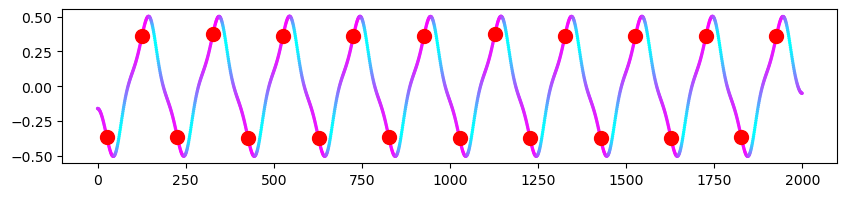

In [5]:
###########################################################################################################
# sweep angle for internal head direction

onecycleT = numT/(N/2)
start = int(onecycleT)
end = int(numT)

hd_offset = circle_period(center_HD[start:end].reshape(-1)-Head_direction[start:end].reshape(-1))
#smooth with gaussian filter
hd_offset = gaussian_filter1d(hd_offset, sigma=10)

max_fr = gaussian_filter1d(max_bump_activity[start:end], sigma=10) #sigma=30 more smooth to remove more than two peaks in a cycle
pks_hdfr, _ = find_peaks(max_fr)
hd_sweep_angle = hd_offset[pks_hdfr]
#mean of positive - mean of negative
mean_hd_sweep_angle = (np.mean(hd_sweep_angle[hd_sweep_angle>0]) - np.mean(hd_sweep_angle[hd_sweep_angle<0]))/2

#sanity check
fig = plt.figure(figsize=(10, 2), dpi=100)
plt.scatter(time_steps[start:end]-time_steps[start], 
            hd_offset, 
            c=max_bump_activity[start:end], 
            cmap='cool', s=s_size)
plt.plot(pks_hdfr, hd_offset[pks_hdfr],'r.',markersize=20)

print('HD sweep angle:', mean_hd_sweep_angle*180/np.pi)
print('HD sweep angle std:', np.std(np.abs(hd_sweep_angle))*180/np.pi)
###########################################################################################################
# sweep angle for internal grid cell location
dis_x_grid = circle_period(center_grid[start:end, 0].reshape(-1)-Animal_location[start:end, 0].reshape(-1))
dis_y_grid = circle_period(center_grid[start:end, 1].reshape(-1)-Animal_location[start:end, 1].reshape(-1))
dis_vec = bm.array([dis_x_grid, dis_y_grid])
moving_vec = bm.array([bm.sqrt(2)/2, bm.sqrt(2)/2]).reshape(1,2)
projection = bm.matmul(moving_vec, dis_vec).reshape(-1,)

#smooth with gaussian filter, then seems like no need of calculate the width of the peak
projection = gaussian_filter1d(projection, sigma=10)

peaks_grid, _ = find_peaks(projection)
troughs_grid, _ = find_peaks(-projection)

#calculate sweep angle
W_rotate = np.array([[np.cos(np.pi/4), -np.sin(np.pi/4)], [np.sin(np.pi/4), np.cos(np.pi/4)]])
Dis = np.array([dis_x_grid, dis_y_grid])
Dis_rotate = np.matmul(W_rotate, Dis)
max_r_grid = np.max(r_grid, axis=1) 

Start = Dis_rotate[:, troughs_grid]
End = Dis_rotate[:, peaks_grid]

num_cycle = troughs_grid.shape[0]-1
gc_sweep_angle = np.zeros(num_cycle)
# for i in range(num_cycle):
#     ax.arrow(Start[0,i], Start[1,i], End[0,i], End[1,i], head_width=0.1, head_length=0.05, fc='red', ec='red')
#     sweep_direction[i] = np.arctan((End[0,i]-Start[0,i])/(End[1,i]-Start[1,i]))

for i in range(num_cycle):
    # ax.arrow(0, 0, End[0,i], End[1,i], head_width=0.1, head_length=0.05, fc='#F18D00', ec='#F18D00')
    gc_sweep_angle[i] = np.arctan((End[0,i]-0)/(End[1,i]-0))

print('Grid cell sweep angle:', np.mean(np.abs(gc_sweep_angle))*180/np.pi)
print('Grid cell sweep angle std:', np.std(np.abs(gc_sweep_angle))*180/np.pi)

###########################################################################################################
# sweep length for internal grid cell location

#norm of dis_vec
norm_dis = bm.sqrt(dis_x_grid**2 + dis_y_grid**2)
#smooth with gaussian filter
norm_dis = gaussian_filter1d(norm_dis, sigma=10)
peak_dist = norm_dis[peaks_grid]
trough_dist = norm_dis[troughs_grid]

print('sweep length of grid cell sweeps', np.mean(peak_dist)-np.mean(trough_dist))


### plot the sweep angle for hd and gc merged

In [ ]:

###########################################################################################################
#plot 

fig, ax = plt.subplots(figsize=(3,3), dpi=300)

direction_length = 1.0

labelsize = 10
ticksize = 8

sc = ax.scatter(
                Dis_rotate[0,:],
                Dis_rotate[1,:],
                c=max_r_grid[start:end],
                cmap="cool",
                s=2,
                label='Internal location'
)

# 添加 x=0 处的直线
plt.axvline(x=0, color='k')
# 添加 y=0 处的直线
plt.axhline(y=0, color='k')
ax.set_ylim(-0.5, 0.5*np.pi)
ax.set_xlim(-0.3*np.pi, 0.3*np.pi)

#add text 'front' at north
ax.text(0, 0.55*np.pi, 'Front', fontsize=labelsize, ha='center')
ax.text(-0.45*np.pi, 0, 'Left', fontsize=labelsize, va='center')
ax.text(0.35*np.pi, 0, 'Right', fontsize=labelsize, va='center')

for i in range(num_cycle):
    theta = hd_sweep_angle[i]
    vx1 = direction_length * np.cos(np.pi/2+theta)
    vy1 = direction_length * np.sin(np.pi/2+theta)
    # add arrow edgealpha=0.5, facealpha=0.5
    if i == 0:
        ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.5, label='Internal direction')
    else:
        ax.arrow(0, 0, vx1, vy1, head_width=0.05, head_length=0.1, fc='orange', ec='orange', linewidth=1, alpha=0.5)
    
ax.legend(loc='lower center', fontsize=ticksize, frameon=False, bbox_to_anchor=(0.5, -0.4))
#spines off
ax.axis('off')
#equal aspect
ax.set_aspect('equal')

plt.tight_layout()

plt.savefig('./figures/HD_GC_sweeps_merges.pdf', dpi=300)

### plot hd and gc sweeps over time

In [ ]:

#plot 

numplots = min(troughs_grid.shape[0] -1, 8) 

fig, axs = plt.subplots(1, numplots, figsize=(4, 2), dpi=300)

labelsize = 10
ticksize = 8

direction_length = 0.8

W_rotate = np.array([[np.cos(np.pi/4), np.sin(np.pi/4)], [-np.sin(np.pi/4), np.cos(np.pi/4)]])
Dis = np.array([dis_x_grid, dis_y_grid])
Dis_rotate = np.matmul(W_rotate, Dis)
max_r_grid = np.max(r_grid, axis=1) 

for i in range(numplots):
    ax = axs[i]
    sc = ax.scatter(
                    Dis_rotate[0,troughs_grid[i]:troughs_grid[i+1]],
                    Dis_rotate[1,troughs_grid[i]:troughs_grid[i+1]],
                    c=max_r_grid[start:end][troughs_grid[i]:troughs_grid[i+1]],
                    cmap="cool",
                    s=2,
                    label='Internal location'
    )
    print(np.min(Dis_rotate[0,troughs_grid[i]:troughs_grid[i+1]]))
    
    #add y=0 reference line
    ax.axhline(y=0, color='k', linewidth=1.0)
    
    if i > 0:
        ax.set_yticks([])
        #axis off
        ax.axis('off')
    else:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        ax.set_yticks([-0.4*np.pi,0.4*np.pi])
        ax.set_yticklabels(['right', 'left'], fontsize=labelsize)
        
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_ylim(-0.4*np.pi, 0.4*np.pi)
    ax.set_xlim(0, 1.2*np.max(Dis_rotate[0,troughs_grid[i]:troughs_grid[i+1]]))
    
    #equal axis
    ax.set_aspect('equal')
    
    #add internal direction angle
    
    theta = hd_sweep_angle[i]
    IDx = direction_length * np.cos(theta)
    IDy = direction_length * np.sin(theta)
    
    # add arrow
    ax.arrow(0, 0, IDx, IDy, head_width=0.1, head_length=0.1, fc='orange', ec='orange', linewidth=2, label='Internal direction')
    if i == numplots-3:
        ax.legend(loc='lower center', fontsize=ticksize, bbox_to_anchor=(-0.3, -0.2), ncol=2, frameon=False)

plt.subplots_adjust(wspace=0.0)

plt.tight_layout()

plt.savefig('./figures/HD_GC_sweeps_overtime.pdf', dpi=300)

### calculate the correlation between HD sweep angle and GC sweep angle

In [ ]:
#scatter plot  hd_sweep_angle and gc_sweep_angle
#make gc_sweep_angle and gc_sweep_angle the same size but cutting the last one
if hd_sweep_angle.shape[0] > gc_sweep_angle.shape[0]:
    hd_sweep_angle = hd_sweep_angle[1:]
else:
    gc_sweep_angle = gc_sweep_angle[:len(hd_sweep_angle)] 
    
fig, ax = plt.subplots(figsize=(2.2, 2.2), dpi=300)

labelsize = 10
ticksize = 8

ax.scatter(hd_sweep_angle, gc_sweep_angle, c='#38c7ff', s=50, alpha = 0.5)
ax.plot([-np.pi/4, np.pi/4], [-np.pi/4, np.pi/4], '--', linewidth=1.0, color='black')

# #add reference line of x=0 and y=0
# ax.axhline(y=0, color='k', linewidth=0.5)
# ax.axvline(x=0, color='k', linewidth=0.5)
#move x and y axis to the center with origin at (0,0)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')


#set xlim from -60 to 60 degree
ax.set_xlim(-np.pi/3, np.pi/3)
ax.set_xticks([-np.pi/3, np.pi/3])
ax.set_xticklabels([r'$-60\degree$', r'$60\degree$'])
ax.set_ylim(-np.pi/3, np.pi/3)
ax.set_yticks([-np.pi/3, np.pi/3])
ax.set_yticklabels([r'$-60\degree$', r'$60\degree$'])

# ax.set_xlabel('GC sweep angle', fontsize=labelsize)
# ax.set_ylabel('HD sweep angle', fontsize=labelsize)
#move x and y at the bottom and left
ax.xaxis.set_label_coords(0.5, -0.05)
ax.yaxis.set_label_coords(-0.1, 0.5)
#set xlabel and ylabel
ax.set_xlabel('ID sweep angle', fontsize=labelsize)
ax.set_ylabel('IL sweep angle', fontsize=labelsize)

#ticksize
ax.tick_params(labelsize=ticksize)

#add left/right text on top left corner
ax.text(-0.32*np.pi, 0.30*np.pi, 'L/R', fontsize=ticksize)
#add right/tight on top right corner
ax.text(0.22*np.pi, 0.30*np.pi, 'R/R', fontsize=ticksize)
#add left/left on bottom left corner
ax.text(-0.32*np.pi, -0.32*np.pi, 'L/L', fontsize=ticksize)
#add right/right on bottom right corner
ax.text(0.22*np.pi, -0.32*np.pi, 'R/L', fontsize=ticksize)

#equal aspect
ax.set_aspect('equal')

plt.tight_layout()

plt.savefig('./figures/HD_GC_sweep_angle_correlation.pdf', dpi=300)


In [ ]:
hd_sweep_angle.shape

In [ ]:
gc_sweep_angle.shape